In [1]:
import logging

import numpy as np
import probtorch
import torch

import bouncing_ball
import bouncing_ball_data
import combinators
import importance
import utils

In [2]:
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection

import matplotlib.pyplot as plt

In [3]:
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

In [4]:
## dataset parameters
T = 75 ## sequence length
num_series = 1
dt = 1 ## \delta t
Boundary = 6 ## unit box is amplified by this value, centered at origin
signal_noise_ratio = 0.2 # the noise is multiplied by this param
D = 2
## Model parameters
K =  4## number of hidden states

In [5]:
## generate time series
x0, y0, init_v, init_v_rand_dir = bouncing_ball_data.intialization(T, num_series, Boundary)
final_mus = np.zeros((num_series, K, D))
final_covs = np.zeros((num_series, K, D, D))
STATEs = np.zeros((num_series, T+1, 4))
Disps = np.zeros((num_series, T, D))
As_true = np.zeros((num_series, 4, 4))
As_pred = np.zeros((num_series, K, K))
for s in range(num_series):
    init_state = np.array([x0[s], y0[s], init_v_rand_dir[s, 0], init_v_rand_dir[s, 1]])
    STATEs[s], Disps[s], As_true[s] = bouncing_ball_data.generate_data(T, dt, init_state, Boundary, signal_noise_ratio)

In [6]:
num_particles = (100,)

In [7]:
bouncing_ball_step = combinators.PrimitiveCall(bouncing_ball.bouncing_ball_step)

In [8]:
prior_init_params = {
    'position_0': {
        'loc': torch.rand(2) * Boundary,
        'scale': torch.ones(2),
    },
    'alpha_0': {
        'concentration': torch.ones(4),
    },
    'alpha_1': {
        'concentration': torch.ones(4),
    },
    'alpha_2': {
        'concentration': torch.ones(4),
    },
    'alpha_3': {
        'concentration': torch.ones(4),
    },
    'alpha_4': {
        'concentration': torch.ones(4),
    },
    'directions': {
        'angle': {
            'concentration1': torch.ones(()),
            'concentration0': torch.ones(()),
        },
        'scale': {
            'loc': torch.eye(2).expand(4, 2, 2),
            'scale': torch.ones(4, 2, 2),
        },
    },
}

In [9]:
init_bouncing_ball = combinators.HyperPopulation(bouncing_ball.init_bouncing_ball, num_particles, hyper=prior_init_params)

In [10]:
bouncing_ball_smc = importance.smc(bouncing_ball_step, num_particles, lambda: range(T), initializer=init_bouncing_ball)

In [11]:
variational_init_params = {
    'position_0': {
        'loc': torch.rand(2) * Boundary,
        'scale': torch.ones(2),
    },
    'alpha_0': {
        'concentration': torch.ones(4),
    },
    'alpha_1': {
        'concentration': torch.Tensor([0.40, 0.20, 0.20, 0.20]),
    },
    'alpha_2': {
        'concentration': torch.Tensor([0.20, 0.40, 0.20, 0.20]),
    },
    'alpha_3': {
        'concentration': torch.Tensor([0.20, 0.20, 0.40, 0.20]),
    },
    'alpha_4': {
        'concentration': torch.Tensor([0.20, 0.20, 0.20, 0.40]),
    },
    'directions': {
        'angle': {
            'concentration1': torch.ones(()),
            'concentration0': torch.ones(()),
        },
        'scale': {
            'loc': torch.ones(4, 2, 2),
            'scale': torch.ones(4, 2, 2) * 0.1,
        },
    },
}

In [12]:
def generate_trajectory_trace(s):
    trajectory = torch.Tensor(STATEs[s])
    displacements = torch.Tensor(Disps[s])

    data = {}

    for i, point in enumerate(trajectory):
        data['position_%d' % i] = torch.Tensor(point[:2])
        if i >= 1:
            data['displacement_%d' % i] = displacements[i-1]
    
    return trajectory, displacements, data

In [13]:
def accumulate_trajectory(inference):
    result = torch.zeros(num_particles[0], len(trajectory), 2)
    result[:, 0] = inference['position_0'].value
    for t in range(len(trajectory) - 1):
        result[:, t+1] = result[:, t] + inference['displacement_%d' % (t+1)].value
    return result

In [14]:
def graph_position_trajectory(positions, T, s):
    gs = gridspec.GridSpec(2, 2)
    fig1 = plt.figure(figsize=(5, 5))
    ax1 = fig1.gca()

    ax1.scatter(positions[:, 0], positions[:, 1], c=np.arange(T))
    ax1.set_xlim([-Boundary, Boundary])
    ax1.set_ylim([-Boundary, Boundary])
    #ax1.set_xticks([])
    #ax1.set_yticks([])
    ax1.set_ylabel('y(t)')
    ax1.set_xlabel('x(t)')
    plt.savefig('position_trajectory_%d.pdf' % s)

In [15]:
def graph_displacement_trajectories(velocity_steps, displacements, T, s):
    fig2, (ax2, ax3) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(5, 5))

    dx_lc = LineCollection(velocity_steps[:, :, :2].numpy())
    dx_lc.set_array(np.arange(T - 1))
    ax2.add_collection(dx_lc)
    ax2.scatter(np.arange(T), displacements[:, 0], c=np.arange(T), s=10)
    #ax2.set_xlabel('t')
    ax2.set_ylabel('Δx')

    dy_lc = LineCollection(velocity_steps[:, :, 0:3:2].numpy())
    dy_lc.set_array(np.arange(T-1))
    ax3.add_collection(dy_lc)
    ax3.scatter(np.arange(T), displacements[:, 1], c=np.arange(T), s=10)
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Δy')

    plt.savefig('time_vs_displacement_%d.pdf' % s)

In [16]:
def graph_velocity_frequencies(directions):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.gca()

    ax.scatter(init_v[:, 0], init_v[:, 1], label='z=1')
    ax.scatter(init_v[:, 0], -init_v[:, 1], label='z=2')
    ax.scatter(-init_v[:, 0], -init_v[:, 1], label='z=3')
    ax.scatter(-init_v[:, 0], init_v[:, 1], label='z=4')
    colors = ['b', 'orange', 'g', 'r', 'k']
    for k in range(K):
        ax.scatter(directions[:, k, 0], directions[:, k, 1], c=colors[k], marker='x')

    ax.set_xlabel('X velocity')
    ax.set_ylabel('Y velocity')
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4)
    plt.savefig('velocity_frequencies.pdf')

11/26/2018 07:31:05 EUBO=8.48692383e+02 at epoch 1
11/26/2018 07:31:06 EUBO=6.43491028e+02 at epoch 2
11/26/2018 07:31:07 EUBO=7.37529663e+02 at epoch 3
11/26/2018 07:31:07 EUBO=2.21942188e+03 at epoch 4
11/26/2018 07:31:08 EUBO=6.57472534e+02 at epoch 5
11/26/2018 07:31:08 EUBO=4.68988586e+02 at epoch 6
11/26/2018 07:31:09 EUBO=2.82430298e+02 at epoch 7
11/26/2018 07:31:10 EUBO=3.28091309e+02 at epoch 8
11/26/2018 07:31:10 EUBO=3.27794952e+02 at epoch 9
11/26/2018 07:31:11 EUBO=4.07235901e+02 at epoch 10
11/26/2018 07:31:11 EUBO=3.69463257e+02 at epoch 11
11/26/2018 07:31:12 EUBO=5.91503601e+02 at epoch 12
11/26/2018 07:31:13 EUBO=5.00766785e+02 at epoch 13
11/26/2018 07:31:14 EUBO=4.47909241e+02 at epoch 14
11/26/2018 07:31:15 EUBO=2.08666351e+02 at epoch 15
11/26/2018 07:31:16 EUBO=6.47498108e+02 at epoch 16
11/26/2018 07:31:18 EUBO=1.42288391e+02 at epoch 17
11/26/2018 07:31:19 EUBO=4.62943237e+02 at epoch 18
11/26/2018 07:31:20 EUBO=3.49290527e+02 at epoch 19
11/26/2018 07:31:21 E

Epoch   399: reducing learning rate of group 0 to 5.0000e-03.


11/26/2018 07:39:40 EUBO=1.42863525e+02 at epoch 401
11/26/2018 07:39:42 EUBO=3.26007767e+01 at epoch 402
11/26/2018 07:39:43 EUBO=-2.85020676e+01 at epoch 403
11/26/2018 07:39:45 EUBO=1.95312744e+02 at epoch 404
11/26/2018 07:39:46 EUBO=1.03842308e+02 at epoch 405
11/26/2018 07:39:47 EUBO=6.66778015e+02 at epoch 406
11/26/2018 07:39:48 EUBO=1.25731224e+02 at epoch 407
11/26/2018 07:39:50 EUBO=8.07501602e+01 at epoch 408
11/26/2018 07:39:52 EUBO=2.28877487e+02 at epoch 409
11/26/2018 07:39:54 EUBO=6.97517624e+01 at epoch 410
11/26/2018 07:39:55 EUBO=1.07399207e+03 at epoch 411
11/26/2018 07:39:57 EUBO=7.74743118e+01 at epoch 412
11/26/2018 07:39:58 EUBO=2.80445129e+02 at epoch 413
11/26/2018 07:39:59 EUBO=1.62658417e+02 at epoch 414
11/26/2018 07:40:01 EUBO=4.31706329e+02 at epoch 415
11/26/2018 07:40:02 EUBO=1.02914925e+02 at epoch 416
11/26/2018 07:40:03 EUBO=2.31101013e+02 at epoch 417
11/26/2018 07:40:04 EUBO=1.33926849e+02 at epoch 418
11/26/2018 07:40:06 EUBO=6.09797485e+02 at ep

Epoch   600: reducing learning rate of group 0 to 2.5000e-03.


11/26/2018 07:44:11 EUBO=3.91490051e+02 at epoch 602
11/26/2018 07:44:12 EUBO=6.14651222e+01 at epoch 603
11/26/2018 07:44:14 EUBO=3.31714905e+02 at epoch 604
11/26/2018 07:44:15 EUBO=2.25287384e+02 at epoch 605
11/26/2018 07:44:17 EUBO=3.20729797e+02 at epoch 606
11/26/2018 07:44:18 EUBO=1.36289337e+02 at epoch 607
11/26/2018 07:44:19 EUBO=1.56229446e+02 at epoch 608
11/26/2018 07:44:21 EUBO=1.54953812e+02 at epoch 609
11/26/2018 07:44:22 EUBO=2.57911499e+02 at epoch 610
11/26/2018 07:44:24 EUBO=3.24308258e+02 at epoch 611
11/26/2018 07:44:25 EUBO=5.45734138e+01 at epoch 612
11/26/2018 07:44:27 EUBO=2.32105606e+02 at epoch 613
11/26/2018 07:44:28 EUBO=3.39876709e+02 at epoch 614
11/26/2018 07:44:30 EUBO=3.89466675e+02 at epoch 615
11/26/2018 07:44:32 EUBO=1.96077499e+02 at epoch 616
11/26/2018 07:44:33 EUBO=2.56996277e+02 at epoch 617
11/26/2018 07:44:34 EUBO=1.47210938e+02 at epoch 618
11/26/2018 07:44:35 EUBO=2.37477631e+02 at epoch 619
11/26/2018 07:44:36 EUBO=4.39331268e+02 at epo

Epoch   801: reducing learning rate of group 0 to 1.2500e-03.


11/26/2018 07:49:09 EUBO=2.87255737e+02 at epoch 803
11/26/2018 07:49:11 EUBO=1.35587769e+02 at epoch 804
11/26/2018 07:49:12 EUBO=3.69836884e+02 at epoch 805
11/26/2018 07:49:13 EUBO=4.02155304e+02 at epoch 806
11/26/2018 07:49:14 EUBO=3.17986725e+02 at epoch 807
11/26/2018 07:49:16 EUBO=4.16764648e+02 at epoch 808
11/26/2018 07:49:17 EUBO=3.06718933e+02 at epoch 809
11/26/2018 07:49:18 EUBO=6.64840012e+01 at epoch 810
11/26/2018 07:49:20 EUBO=3.37677490e+02 at epoch 811
11/26/2018 07:49:21 EUBO=2.02025467e+02 at epoch 812
11/26/2018 07:49:22 EUBO=2.71326050e+03 at epoch 813
11/26/2018 07:49:24 EUBO=1.94991119e+02 at epoch 814
11/26/2018 07:49:25 EUBO=3.47950928e+02 at epoch 815
11/26/2018 07:49:26 EUBO=1.49711700e+02 at epoch 816
11/26/2018 07:49:28 EUBO=4.28680298e+02 at epoch 817
11/26/2018 07:49:29 EUBO=-7.61626530e+00 at epoch 818
11/26/2018 07:49:30 EUBO=8.90665970e+01 at epoch 819
11/26/2018 07:49:32 EUBO=8.11459122e+01 at epoch 820
11/26/2018 07:49:33 EUBO=6.97259045e+00 at ep

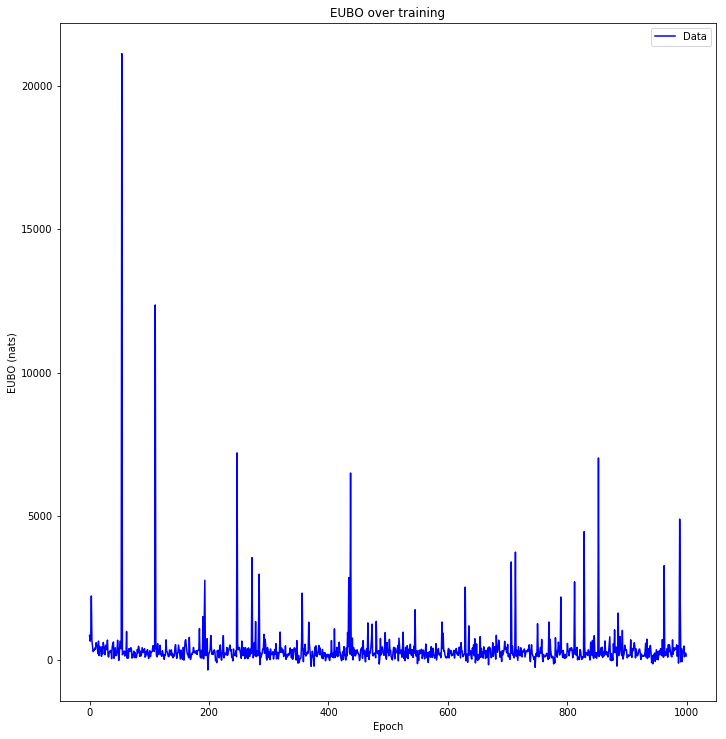

KeyError: 'position_0'

In [17]:
modal_directions = torch.zeros(num_series, K, 2)

for s in range(num_series):
    trajectory, displacements, data = generate_trajectory_trace(s)
    init_proposal = combinators.HyperPopulation(bouncing_ball.init_bouncing_ball, num_particles,
                                                trainable=variational_init_params)
    bouncing_ball_proposal = importance.smc(bouncing_ball_step, num_particles, lambda: range(T), initializer=init_proposal)
    
    importance_sampler = combinators.score_under_proposal(bouncing_ball_smc, bouncing_ball_proposal)
    
    inference, trained_params, eubos = importance.variational_importance(
        importance_sampler, 1000, data,
        use_cuda=False, lr=1e-2, inclusive_kl=True,
        patience=200,
    )
    trained_params = init_proposal.args_vardict()
    utils.plot_evidence_bounds(eubos, False)
    
    init_posterior = combinators.PrimitiveCall(bouncing_ball.init_bouncing_ball,
                                               hyper=trained_params)
    bouncing_ball_posterior = combinators.Reduce(bouncing_ball_step, lambda: range(T), initializer=init_posterior)
    _, inference, _ = bouncing_ball_posterior.simulate()
    inferred_trajectory = accumulate_trajectory(inference)
    
    positions = torch.stack([inferred_trajectory[:, t+1] for t in range(T)], dim=1).mean(dim=0).cpu().detach()
    displacements = torch.stack([inference['displacement_%d' % (t+1)].value for t in range(T)], dim=1).mean(dim=0).cpu().detach()
    step_numbers = torch.stack((torch.arange(T), torch.arange(T) + 1), dim=-1)
    velocity_srcs = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements), displacements[:-1]), dim=1)
    velocity_dests = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements) + 1, displacements[1:]), dim=1)
    velocity_steps = torch.stack((velocity_srcs, velocity_dests), dim=1)
    
    graph_position_trajectory(positions, T, s)
    graph_displacement_trajectories(velocity_steps, displacements, T, s)
    
    alpha = torch.tensor(trained_params['directions']['angle']['concentration1'])
    beta = torch.tensor(trained_params['directions']['angle']['concentration0'])
    mean_angle = torch.distributions.Beta(alpha, beta).mean  * np.pi/2
    modal_directions[s] = bouncing_ball.reflect_directions(mean_angle)
    mean_angle = inference['directions__angle'].value.mean(dim=0).detach().cpu() * np.pi/2
    final_mus[s] = bouncing_ball.reflect_directions(mean_angle).numpy()
    final_covs[s] = inference['directions__scale'].value.mean(dim=0).detach().cpu().numpy()
    for k in range(K):
        As_pred[s][k] = inference['A_%d' % (k+1)].value.mean(dim=0).detach().cpu().numpy()
    
    plt.close('all')

graph_velocity_frequencies(modal_directions.detach().numpy())

In [ ]:
import bouncing_ball_plots

In [ ]:
fs = 3 ## figure size
vmax = 0.3 ## cmap maximum value, to make off-diagonal elements more visible
width_space = 0.05 # space between figures
height_space = 0.05 # space between figures
cov_flag = False # plot the covariances or not
legend_flag = False # plot the legend bar or not
save_flag = True ## save or not

In [ ]:
## plot method 1
bouncing_ball_plots.plot_circle_transition(init_v, final_mus, final_covs,
                                           As_pred, As_true, K, fs, vmax, width_space, height_space, cov_flag, legend_flag, save_flag)

In [ ]:
## plot method 2
bouncing_ball_plots.plot_circle_transition_colorcode(init_v, final_mus, final_covs, As_pred, As_true, K, fs, vmax, width_space, height_space, cov_flag, legend_flag, save_flag)

In [ ]:
def plot_circle_transition_colorcode(init_v, final_mus, final_covs, As_pred, As_true, K, fs, vmax, width_space, height_space, cov_flag, legend_flag, save_flag):

    As_infer = As_pred / As_pred.sum(-1)[:, :, None]
    As_infer = As_infer.mean(0)
    As_true_ave = As_true.mean(0)

    fig = plt.figure(figsize=(fs*1.5 + width_space,fs + height_space))
    gs1 = gridspec.GridSpec(1, 1)
    # , width_ratios=[2,1], height_ratios=[1,1]
    gs1.update(left=0.0, bottom=0.0, right=(2/3), top=1.0, wspace=width_space, hspace=height_space)
    ax1 = fig.add_subplot(gs1[0])

    # ax3 = fig.add_subplot(gs[1, 1])
    ax1.set_xticks([])
    ax1.set_yticks([])

    gs2 = gridspec.GridSpec(4, 1)
    gs2.update(left=2/3 + (1/3)*width_space, bottom=0.5+(1/2)*width_space, right=1.0, top=1.0, wspace=0, hspace=0)
    ax2 = fig.add_subplot(gs2[0, 0])
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax3 = fig.add_subplot(gs2[1, 0])
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax4 = fig.add_subplot(gs2[2, 0])
    ax4.set_xticks([])
    ax4.set_yticks([])
    ax5 = fig.add_subplot(gs2[3, 0])
    ax5.set_xticks([])
    ax5.set_yticks([])

    gs3 = gridspec.GridSpec(4, 1)
    gs3.update(left=2/3 + (1/3)*width_space, bottom=0.0, right=1.0, top=0.5 - (1/2)*width_space, wspace=0, hspace=0)
    ax6 = fig.add_subplot(gs3[0, 0])
    ax6.set_xticks([])
    ax6.set_yticks([])
    ax7 = fig.add_subplot(gs3[1, 0])
    ax7.set_xticks([])
    ax7.set_yticks([])
    ax8 = fig.add_subplot(gs3[2, 0])
    ax8.set_xticks([])
    ax8.set_yticks([])
    ax9 = fig.add_subplot(gs3[3, 0])
    ax9.set_xticks([])
    ax9.set_yticks([])
    markersize = 10.0
    colors = ['b', 'Purple', 'g', 'r']
    ## plot left one
    ax1.scatter(init_v[:,0], init_v[:,1], s=markersize, color=colors[0], label='z=1')
    ax1.scatter(init_v[:,0], -init_v[:,1], s=markersize, color=colors[1], label='z=2')
    ax1.scatter(-init_v[:,0], -init_v[:,1], s=markersize, color=colors[2], label='z=3')
    ax1.scatter(-init_v[:,0], init_v[:,1], s=markersize, color=colors[3], label='z=4')

    for k in range(K):
        ax1.scatter(final_mus[:,k,0], final_mus[:,k,1], c=colors[k], marker='x')
    if cov_flag:
        for k in range(K):
            for s in range(num_series):
                plot_cov_ellipse(cov=final_covs[s, k, :, :], pos=final_mus[s, k, :], nstd=0.3, ax=ax1, alpha=0.3)
    #    ax1.set_xlabel('x velocity')
    #    ax1.set_ylabel('y velocity')
    if legend_flag:
        ax1.legend(loc='upper center', bbox_to_anchor=(0.75, 1.15), ncol=4)

    ax2.imshow(As_infer[None, 0,:], cmap='Blues', vmin=0, vmax=vmax)
    ax3.imshow(As_infer[None, 1,:], cmap='Purples', vmin=0, vmax=vmax)
    ax4.imshow(As_infer[None, 2,:], cmap='Greens', vmin=0, vmax=vmax)
    ax5.imshow(As_infer[None, 3,:], cmap='Reds', vmin=0, vmax=vmax)

    ax6.imshow(As_true_ave[None, 0,:], cmap='Blues', vmin=0, vmax=vmax)
    ax7.imshow(As_true_ave[None, 1,:], cmap='Purples', vmin=0, vmax=vmax)
    ax8.imshow(As_true_ave[None, 2,:], cmap='Greens', vmin=0, vmax=vmax)
    ax9.imshow(As_true_ave[None, 3,:], cmap='Reds', vmin=0, vmax=vmax)

    if save_flag:
        fig.savefig('combinator_results.pdf', dpi=600, bbox_inches='tight')
        fig.savefig('combinator_results.svg', dpi=600, bbox_inches='tight')
        fig.savefig('combinator_results.png', dpi=600, bbox_inches='tight')

In [ ]:
## plot method 2
plot_circle_transition_colorcode(init_v, final_mus, final_covs, As_pred, As_true, K, fs, vmax, width_space, height_space, cov_flag, legend_flag, save_flag)